In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import pathlib

import functools

import vlbi

figsize = [10,7]

c = 299792458 # speed of light in m/s
fs = 40000

In [2]:
observation = np.dtype([('utc', np.float32), ('delta_range', np.float32), ('delta_velocity', np.float32), ('freq', np.float32), ('max_corr', np.float32)])

def compute_observation(data):
    time = data['time'][0] + 0.5*data['corr'].size/fs
    corr_peak = np.argmax(np.abs(data['corr']))
    corr_peak += vlbi.peak_estimator_parabola(np.abs(data['corr'][corr_peak-1:corr_peak+2]))
    delta_range = vlbi.delta_range(corr_peak, data['corr'].size, data['time'][0] - data['time'][1])
    delta_velocity =  -(data['freq_bin']*fs/data['corr'].size + data['f_lo'][0,0] - data['f_lo'][1,0]) * c / data['freq']
    return time, delta_range, delta_velocity, data['freq'], np.max(np.abs(data['corr']))

In [3]:
path = pathlib.Path('vlbi_20180610')

In [4]:
observations = np.fromiter((compute_observation(np.load(str(p))) for p in path.iterdir()), dtype=observation)
# filter by delta_range
observations = observations[np.abs(observations['delta_range']) < 10e6]

In [5]:
def range_doppler(tracking):
    return np.sqrt(np.sum(tracking[:,0:3]**2, axis=1))*1e3

In [6]:
trk = vlbi.load_doppler_file('VLBI_Doppler.txt')
delta_range = range_doppler(trk[:,1:]) - range_doppler(trk[:,7:])
delta_velocity = vlbi.range_rate(trk[:,1:]) - vlbi.range_rate(trk[:,7:])
utc = vlbi.mjd2unixtimestamp(trk[:,0])

trk = vlbi.load_doppler_file('VLBI_Doppler_old.txt')
delta_range_old = range_doppler(trk[:,1:]) - range_doppler(trk[:,7:])
delta_velocity_old = vlbi.range_rate(trk[:,1:]) - vlbi.range_rate(trk[:,7:])

trk = vlbi.load_doppler_file('VLBI_tracking_20180610.txt')
delta_range_track = range_doppler(trk[:,1:]) - range_doppler(trk[:,7:])
delta_velocity_track = vlbi.range_rate(trk[:,1:]) - vlbi.range_rate(trk[:,7:])

In [7]:
obs_435 = observations[observations['freq'] == 435.4e6]
obs_436 = observations[observations['freq'] == 436.4e6]
start = np.min(observations['utc']) - 120
end = np.max(observations['utc']) + 120
trk_sel = (utc >= start) & (utc <= end)

RMS errors
0.248128516945
0.166543868672
0.156442926566
0.137256


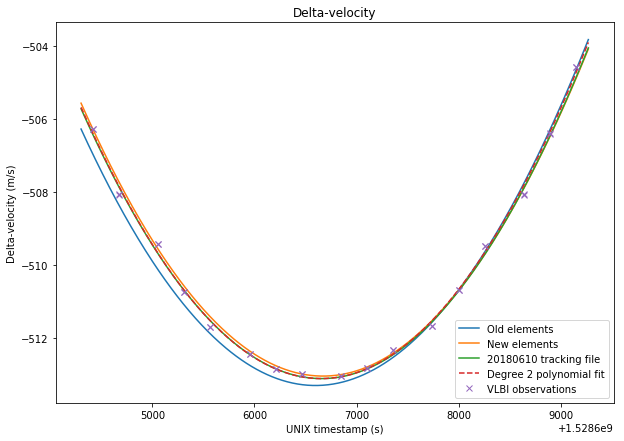

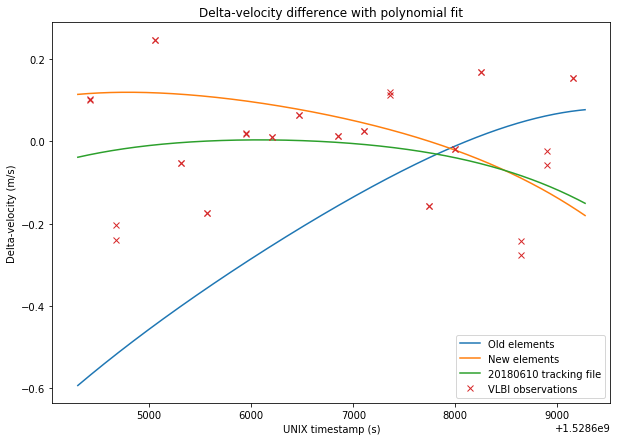

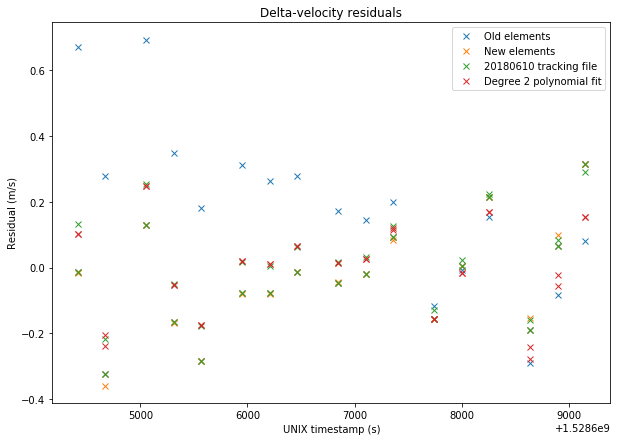

In [8]:
p = np.poly1d(np.polyfit(np.concatenate((obs_435['utc']-obs_435['utc'][0], obs_436['utc']-obs_435['utc'][0])), np.concatenate((obs_435['delta_velocity'], obs_436['delta_velocity'])), 2))

plt.figure(figsize=figsize, facecolor='w')
plt.plot(utc[trk_sel], delta_velocity_old[trk_sel])
plt.plot(utc[trk_sel], delta_velocity[trk_sel])
plt.plot(utc[trk_sel], delta_velocity_track[trk_sel])
plt.plot(utc[trk_sel], p(utc[trk_sel] - obs_435['utc'][0]), '--')
plt.plot(np.concatenate((obs_435['utc'], obs_436['utc'])), np.concatenate((obs_435['delta_velocity'], obs_436['delta_velocity'])), 'x')
plt.title('Delta-velocity')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Delta-velocity (m/s)')
plt.legend(['Old elements', 'New elements', '20180610 tracking file', 'Degree 2 polynomial fit', 'VLBI observations'])

plt.figure(figsize=figsize, facecolor='w')
plt.plot(utc[trk_sel], delta_velocity_old[trk_sel] - p(utc[trk_sel] - obs_435['utc'][0]))
plt.plot(utc[trk_sel], delta_velocity[trk_sel] - p(utc[trk_sel] - obs_435['utc'][0]))
plt.plot(utc[trk_sel], delta_velocity_track[trk_sel] - p(utc[trk_sel] - obs_435['utc'][0]))
plt.plot(np.concatenate((obs_435['utc'], obs_436['utc'])), np.concatenate((obs_435['delta_velocity'] - p(obs_435['utc'] - obs_435['utc'][0]), obs_436['delta_velocity'] - p(obs_436['utc'] - obs_435['utc'][0]))), 'x')
plt.title('Delta-velocity difference with polynomial fit')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Delta-velocity (m/s)')
plt.legend(['Old elements', 'New elements', '20180610 tracking file', 'VLBI observations'])


plt.figure(figsize=figsize, facecolor='w')
plt.plot(np.concatenate((obs_435['utc'], obs_436['utc'])), np.concatenate((obs_435['delta_velocity'] - np.interp(obs_435['utc'], utc, delta_velocity), obs_436['delta_velocity'] - np.interp(obs_436['utc'], utc, delta_velocity_old))), 'x')
plt.plot(np.concatenate((obs_435['utc'], obs_436['utc'])), np.concatenate((obs_435['delta_velocity'] - np.interp(obs_435['utc'], utc, delta_velocity), obs_436['delta_velocity'] - np.interp(obs_436['utc'], utc, delta_velocity))), 'x')
plt.plot(np.concatenate((obs_435['utc'], obs_436['utc'])), np.concatenate((obs_435['delta_velocity'] - np.interp(obs_435['utc'], utc, delta_velocity), obs_436['delta_velocity'] - np.interp(obs_436['utc'], utc, delta_velocity_track))), 'x')
plt.plot(np.concatenate((obs_435['utc'], obs_436['utc'])), np.concatenate((obs_435['delta_velocity'] - p(obs_435['utc'] - obs_435['utc'][0]), obs_436['delta_velocity'] - p(obs_436['utc'] - obs_435['utc'][0]))), 'x')
plt.title('Delta-velocity residuals')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Residual (m/s)')
plt.legend(['Old elements', 'New elements', '20180610 tracking file', 'Degree 2 polynomial fit']);

print('RMS errors')
print(np.sqrt(np.average(np.square(np.concatenate((obs_435['delta_velocity'] - np.interp(obs_435['utc'], utc, delta_velocity), obs_436['delta_velocity'] - np.interp(obs_436['utc'], utc, delta_velocity_old)))))))
print(np.sqrt(np.average(np.square(np.concatenate((obs_435['delta_velocity'] - np.interp(obs_435['utc'], utc, delta_velocity), obs_436['delta_velocity'] - np.interp(obs_436['utc'], utc, delta_velocity)))))))
print(np.sqrt(np.average(np.square(np.concatenate((obs_435['delta_velocity'] - np.interp(obs_435['utc'], utc, delta_velocity), obs_436['delta_velocity'] - np.interp(obs_436['utc'], utc, delta_velocity_track)))))))
print(np.sqrt(np.average(np.square(np.concatenate((obs_435['delta_velocity'] - p(obs_435['utc'] - obs_435['utc'][0]), obs_436['delta_velocity'] - p(obs_436['utc'] - obs_435['utc'][0])))))))


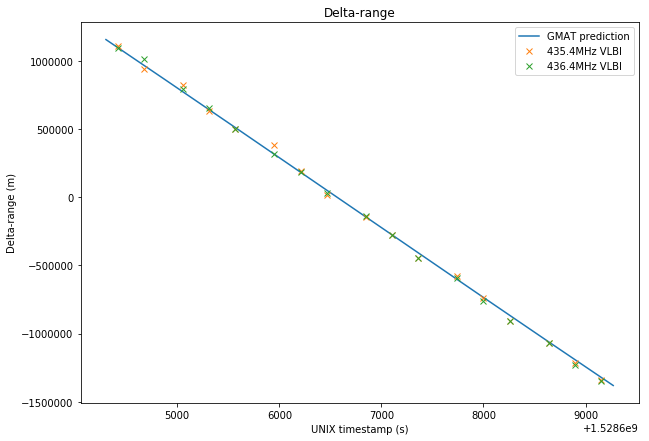

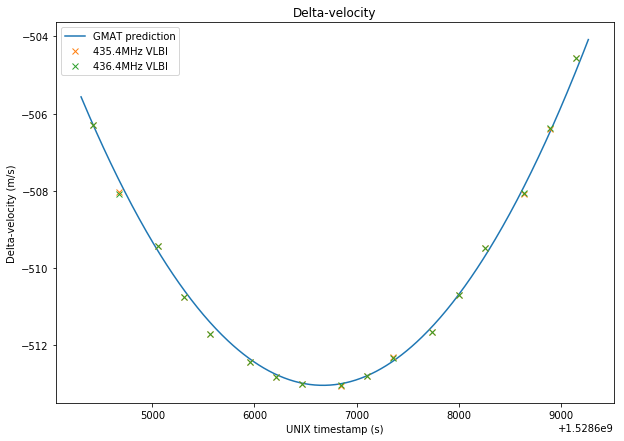

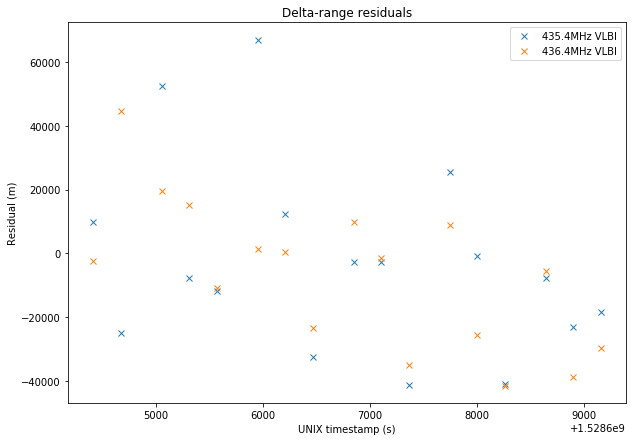

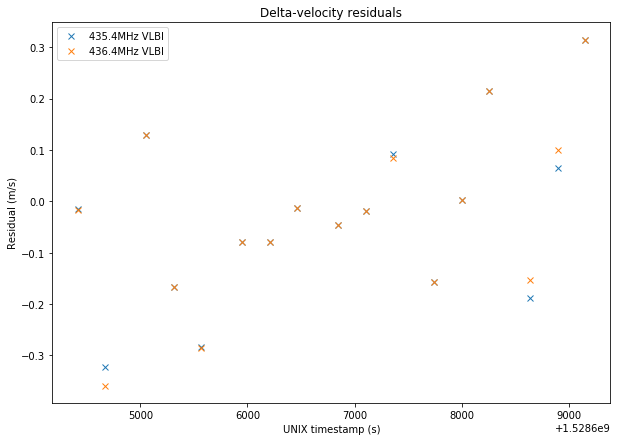

In [9]:
plt.figure(figsize=figsize, facecolor='w')
plt.plot(utc[trk_sel], delta_range[trk_sel])
plt.plot(obs_435['utc'], obs_435['delta_range'], 'x')
plt.plot(obs_436['utc'], obs_436['delta_range'], 'x')
plt.title('Delta-range')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Delta-range (m)')
plt.legend(['GMAT prediction', '435.4MHz VLBI', '436.4MHz VLBI'])
plt.figure(figsize=figsize, facecolor='w')
plt.plot(utc[trk_sel], delta_velocity[trk_sel])
plt.plot(obs_435['utc'], obs_435['delta_velocity'], 'x')
plt.plot(obs_436['utc'], obs_436['delta_velocity'], 'x')
plt.title('Delta-velocity')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Delta-velocity (m/s)')
plt.legend(['GMAT prediction', '435.4MHz VLBI', '436.4MHz VLBI'])
plt.figure(figsize=figsize, facecolor='w')
plt.plot(obs_435['utc'], obs_435['delta_range'] - np.interp(obs_435['utc'], utc, delta_range), 'x')
plt.plot(obs_436['utc'], obs_436['delta_range'] - np.interp(obs_436['utc'], utc, delta_range), 'x')
plt.title('Delta-range residuals')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Residual (m)')
plt.legend(['435.4MHz VLBI', '436.4MHz VLBI'])
plt.figure(figsize=figsize, facecolor='w')
plt.plot(obs_435['utc'], obs_435['delta_velocity'] - np.interp(obs_435['utc'], utc, delta_velocity), 'x')
plt.plot(obs_436['utc'], obs_436['delta_velocity'] - np.interp(obs_436['utc'], utc, delta_velocity), 'x')
plt.title('Delta-velocity residuals')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Residual (m/s)')
plt.legend(['435.4MHz VLBI', '436.4MHz VLBI']);

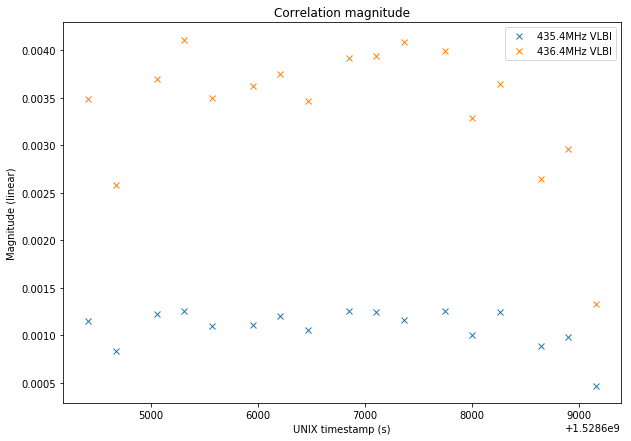

In [10]:
plt.figure(figsize=figsize, facecolor='w')
plt.plot(obs_435['utc'], obs_435['max_corr'], 'x')
plt.plot(obs_436['utc'], obs_436['max_corr'], 'x')
plt.title('Correlation magnitude')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Magnitude (linear)')
plt.legend(['435.4MHz VLBI', '436.4MHz VLBI']);